In this file we explore the dataset without any alteration

# Imports and Configurations

In [107]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import kornia

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [109]:
# Paths
pathTrain = '../train_images/GTSRB/Final_Training/Images'
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 50

# Auxiliary Functions

In [110]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

In [111]:
from skimage.util import random_noise

class RandomMotionBlur:
    def __init__(self, kernel_size=9, angle=180.0, direction=-0.5, p=0.5):
        self.kernel_size = kernel_size
        self.angle = angle
        self.direction = direction
        self.p = p

    def __call__(self, img):
        # Normalize to [0, 1]
        img = img.float() / 255.0

        if torch.rand(1) < self.p:
            img = kornia.filters.motion_blur(img.unsqueeze(0), self.kernel_size, self.angle, self.direction)
            return img.squeeze(0)
        else:
            return img
        
class Noise:
    def __init__(self, mean=0, var=0.05, p=0.5):
        self.mean = mean
        self.var = var
        self.p = p

    def __call__(self, img):
        if torch.rand(1) < self.p:
            noisy_img = torch.tensor(random_noise(img, mode='speckle', mean=self.mean, var=self.var, clip=True))
            return noisy_img
        else:
            return img

# Prepare and Load Data

In [112]:
# Convert the images from ppm to png
from PIL import Image
import glob
def ppm2png():
    images = glob.glob(f'{pathTrain}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)

    images = glob.glob(f'{pathTest}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)
#ppm2png()

At this point we should apply transformations to our dataset

In [113]:
from torchvision.transforms import v2

transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    #v2.ToImage(),
    #Noise(var=0.01,p=0.3),
    #v2.ToPILImage(),
    v2.RandomAutocontrast(p=1.0), # Apply autocontrast to the image
    v2.RandomRotation(15),                             # Will rotate the image randomly by an angle of -15 to 15 degrees
    v2.RandomPerspective(distortion_scale=0.5, p=0.3), # Apply a random perspective transformation to the image
    v2.ToImage(),                                      # Convert to image
    v2.ToDtype(torch.float32, scale=True)              # Normalize to [0,1]
])

transform_test = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [114]:
new_transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ColorJitter(brightness=0.5),        # Randomly change the brightness image by a factor of 0.3 (0.7 to 1.3)
    v2.ToImage(),
    #RandomMotionBlur(kernel_size=7,p=0.5), # Apply motion blur with a given probability
    #Noise(var=0.01,p=0.4),
    v2.ToPILImage(),
    v2.RandomErasing(p=0.4, scale=(0.02, 0.10)), # Randomly erase the image
    v2.RandomCrop(IMAGE_SIZE, padding=4),  # Crop the image to a random size of (32, 32)
    v2.ToImage(),                          
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [115]:
new_transform_train_2 = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),
    RandomMotionBlur(kernel_size=7,p=0.6), # Apply motion blur with a given probability
    Noise(var=0.01,p=0.5),
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [116]:
new_train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=new_transform_train)

In [117]:
new_train_set_2 = torchvision.datasets.ImageFolder(root=pathTrain, transform=new_transform_train_2)

In [118]:
train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=transform_train)

In [119]:
increased_dataset = torch.utils.data.ConcatDataset([train_set, new_train_set])

In [120]:
train_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [121]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape) # [batch_size, channels, height, width]
print(targets) 

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([33, 38, 10, 31, 13, 18, 34, 21, 42, 17,  7, 16,  2,  1,  3, 11, 13, 11,
        16, 14,  9,  4, 13, 35,  4, 10,  9, 41,  2, 18, 14, 12])


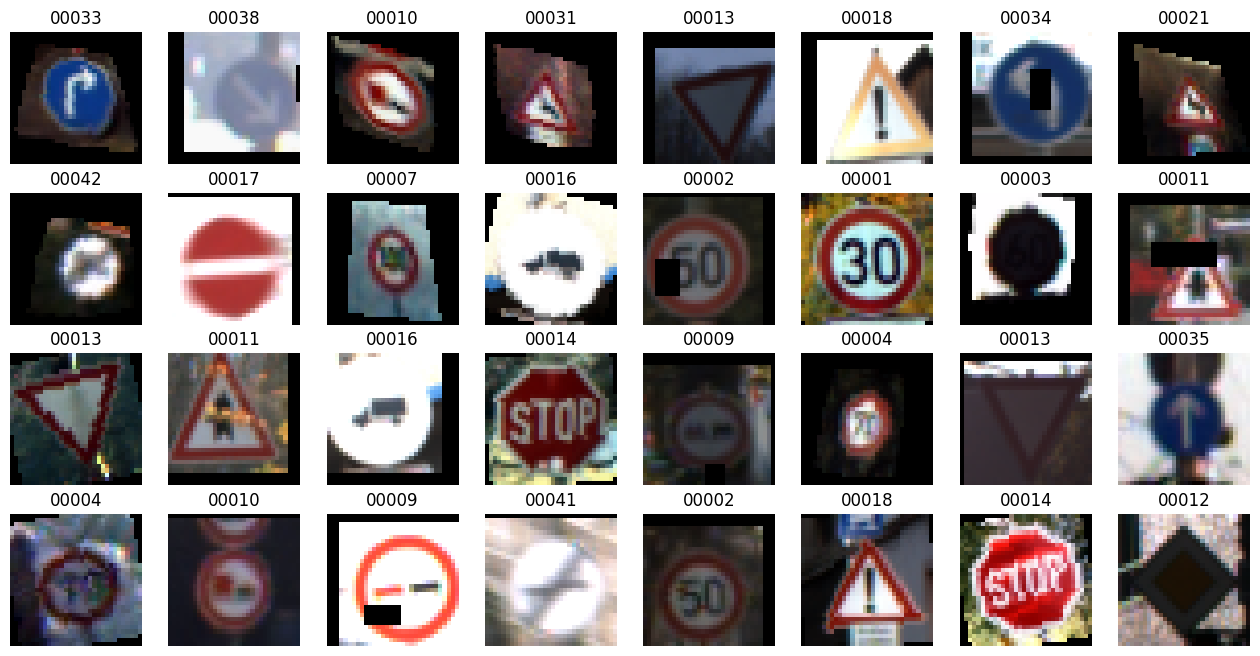

<Figure size 640x480 with 0 Axes>

In [122]:
vcpi_util.show_images(4,8,images, targets, increased_dataset.datasets[0].classes)

# Treino

In [123]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 128, 3) 
        self.bn1 = torch.nn.BatchNorm2d(128)    
        self.relu1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout2d(0.3)

        self.conv2 = torch.nn.Conv2d(128, 256, 3)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.relu2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout2d(0.3)

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(256, 512, 3)
        self.bn3 = torch.nn.BatchNorm2d(512)        
        self.relu3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout2d(0.3)

        self.conv4 = torch.nn.Conv2d(512, 512, 3)
        self.bn4 = torch.nn.BatchNorm2d(512)
        self.relu4 = torch.nn.ReLU()
        self.drop4 = torch.nn.Dropout2d(0.3)

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(12800, num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 128, 30, 30) 
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.conv2(x)                  # output = (batch_size, 256, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.maxpool1(x)               # output = (batch_size, 256, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 512, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)

        x = self.conv4(x)                  # output = (batch_size, 512, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)

        x = self.maxpool2(x)               # output = (batch_size, 512, 5, 5)     512 x 5 x 5 = 12800

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 
    
model_I = Conv(len(train_set.classes))
model_I.to(device)
print(model_I)

torchinfo.summary(model_I, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Conv(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout2d(p=0.3, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (drop4): Dropout2d(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, pa

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 128, 30, 30]         3,584
├─BatchNorm2d: 1-2                       [32, 128, 30, 30]         256
├─ReLU: 1-3                              [32, 128, 30, 30]         --
├─Dropout2d: 1-4                         [32, 128, 30, 30]         --
├─Conv2d: 1-5                            [32, 256, 28, 28]         295,168
├─BatchNorm2d: 1-6                       [32, 256, 28, 28]         512
├─ReLU: 1-7                              [32, 256, 28, 28]         --
├─Dropout2d: 1-8                         [32, 256, 28, 28]         --
├─MaxPool2d: 1-9                         [32, 256, 14, 14]         --
├─Conv2d: 1-10                           [32, 512, 12, 12]         1,180,160
├─BatchNorm2d: 1-11                      [32, 512, 12, 12]         1,024
├─ReLU: 1-12                             [32, 512, 12, 12]       

With Early Stopping

In [124]:
class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):
        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False

c:\Users\inesf\miniconda3\envs\cudaEnv\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


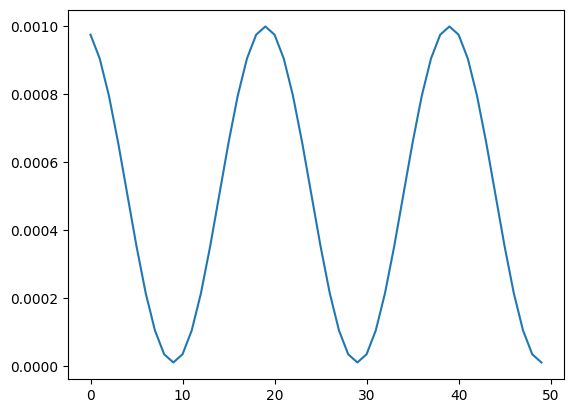

In [125]:
optimizer_aux = torch.optim.Adam(model_I.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_aux, start_factor=1, end_factor=0.1, total_iters =20)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.00001)

lrs = []
for epoch in range(EPOCHS):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [126]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer, scheduler, early_stopper):
    history = {}
    history['accuracy'] = []
    #history['val_acc'] = []
    #history['val_loss'] = []
    history['test_acc'] = []
    history['test_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            t_correct = 0
            test_loss = 0.0            
            for i,t in test_loader:
                i, t = i.to(device), t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                test_loss += loss_fn(o, t)

                t_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(test_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        test_loss = test_loss / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Test Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['test_loss'].append(test_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())

        if early_stopper(test_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)

In [127]:
optimizer_I = torch.optim.Adam(model_I.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor = 0.1, patience=10)
early_stop = Early_Stopping(25)

history_I = train(model_I,train_loader,test_loader,EPOCHS,loss_fn,optimizer_I,scheduler,early_stop)

Epoch: 000; Loss: 0.045586; Accuracy: 61.6313; Test Acc: 97.0388; Elapsed time: 78.7256
Epoch: 001; Loss: 0.011062; Accuracy: 89.6031; Test Acc: 98.4086; Elapsed time: 81.1738
Epoch: 002; Loss: 0.006355; Accuracy: 94.0537; Test Acc: 99.2478; Elapsed time: 81.3395
Epoch: 003; Loss: 0.004803; Accuracy: 95.4615; Test Acc: 98.9945; Elapsed time: 79.8559
Epoch: 004; Loss: 0.003750; Accuracy: 96.4549; Test Acc: 99.1766; Elapsed time: 79.3087
Epoch: 005; Loss: 0.003150; Accuracy: 97.0542; Test Acc: 99.4537; Elapsed time: 79.4011
Epoch: 006; Loss: 0.002799; Accuracy: 97.3335; Test Acc: 99.5249; Elapsed time: 83.5899
Epoch: 007; Loss: 0.002507; Accuracy: 97.6383; Test Acc: 99.3112; Elapsed time: 79.3532
Epoch: 008; Loss: 0.002250; Accuracy: 97.8181; Test Acc: 99.3824; Elapsed time: 79.3242
Epoch: 009; Loss: 0.002062; Accuracy: 98.0336; Test Acc: 99.5249; Elapsed time: 79.4591
Epoch: 010; Loss: 0.002010; Accuracy: 98.0578; Test Acc: 99.5170; Elapsed time: 84.0764
Epoch: 011; Loss: 0.001896; Accu

In [128]:
###### Saving ######
torch.save({
    'epoch': EPOCHS,
    'model':model_I.state_dict(),
    'optimizer': optimizer_I.state_dict(),
    'history' : history_I
    },
    f'model_III_oclude.pt')

# Análise dos Resultados

Although it may coincide, the best epoch considering training data accuracy is not always the best epoch for test data accuracy

In [129]:
best_train = np.asarray(history_I['accuracy']).argmax()
best_test = np.asarray(history_I['test_acc']).argmax()

print('Best epoch for train accuracy:', best_train,' Best epoch for test accuracy:',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history_I['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history_I['test_acc'][best_test])

Best epoch for train accuracy: 49  Best epoch for test accuracy: 45
Test accuracy at epoch  49  : 99.66746 Test accuracy at epoch  45  : 99.786224


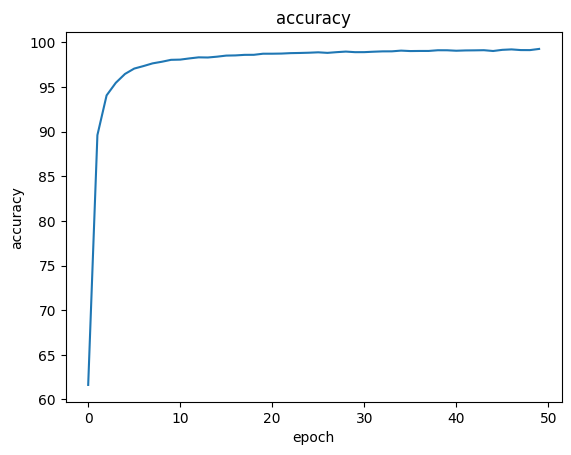

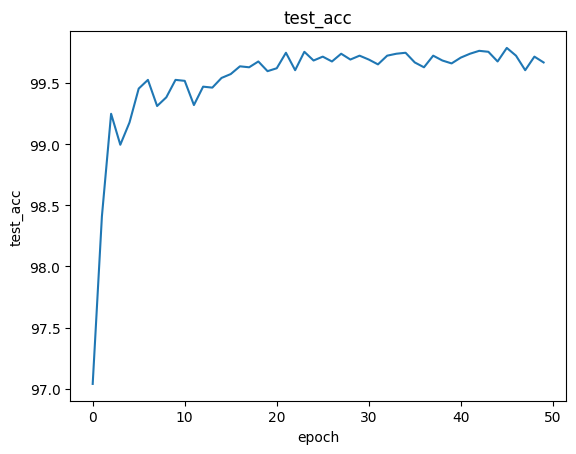

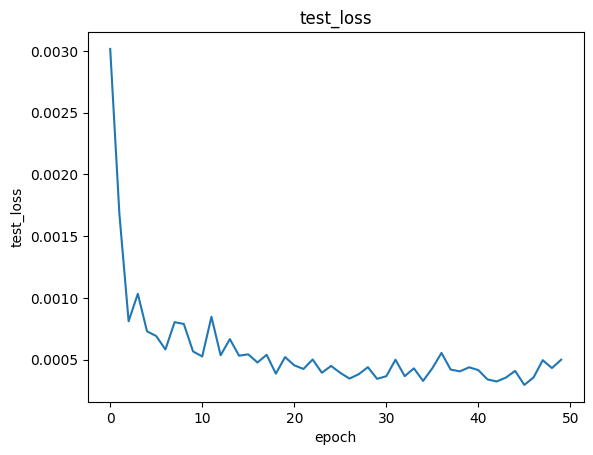

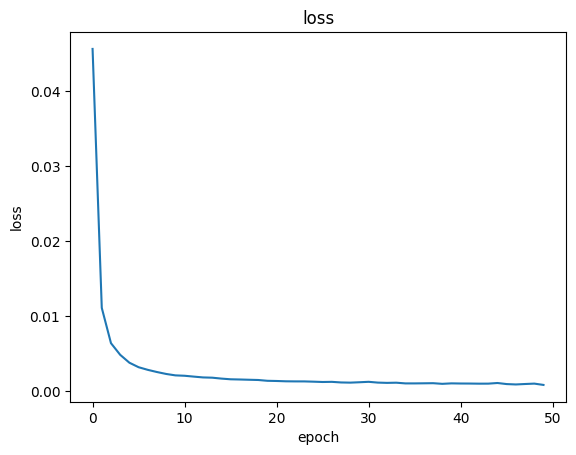

In [130]:
vcpi_util.show_history(history_I)

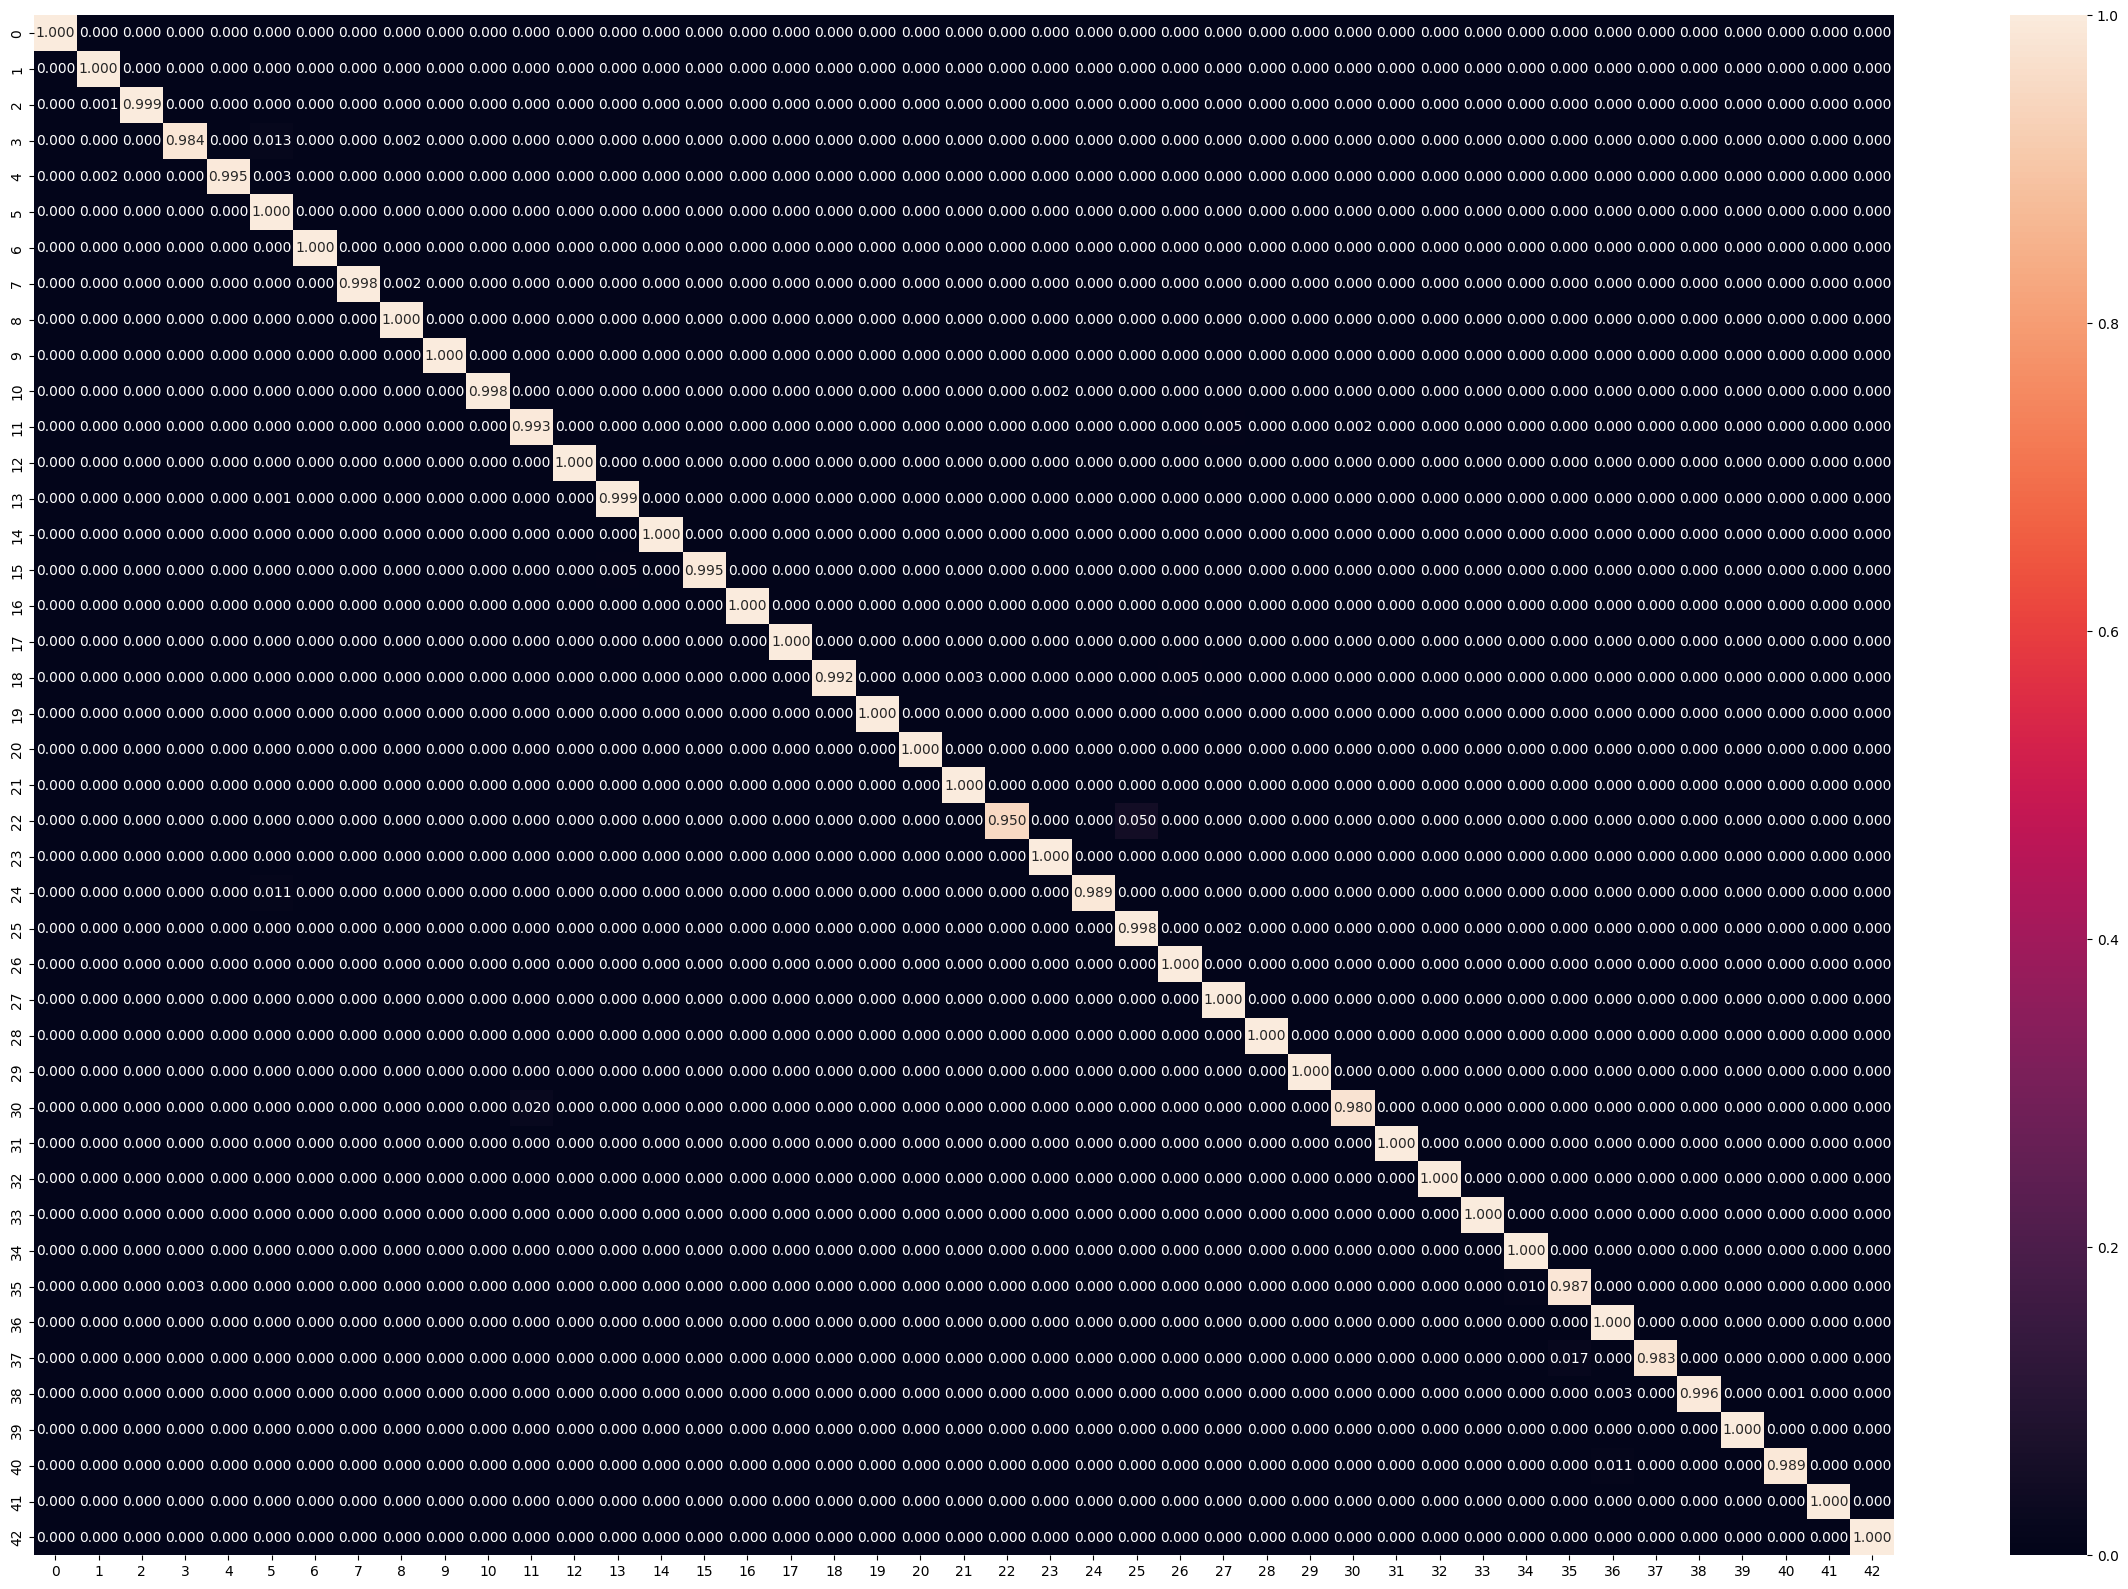

In [131]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_I(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux) 
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(increased_dataset.datasets[0].class_to_idx))

- From the confusion matrix, built from the predictions on the test set, we can see that regarding accuracy, not all classes behave the same way.
- The histogram presented below shows that the classes 0 are severely under represented, so that might justify its bad performance.

In [132]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list,increased_dataset.datasets[0].classes)

In [ ]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(BATCH_SIZE, 3, IMAGE_SIZE,IMAGE_SIZE)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 32 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 32:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 10, 3)

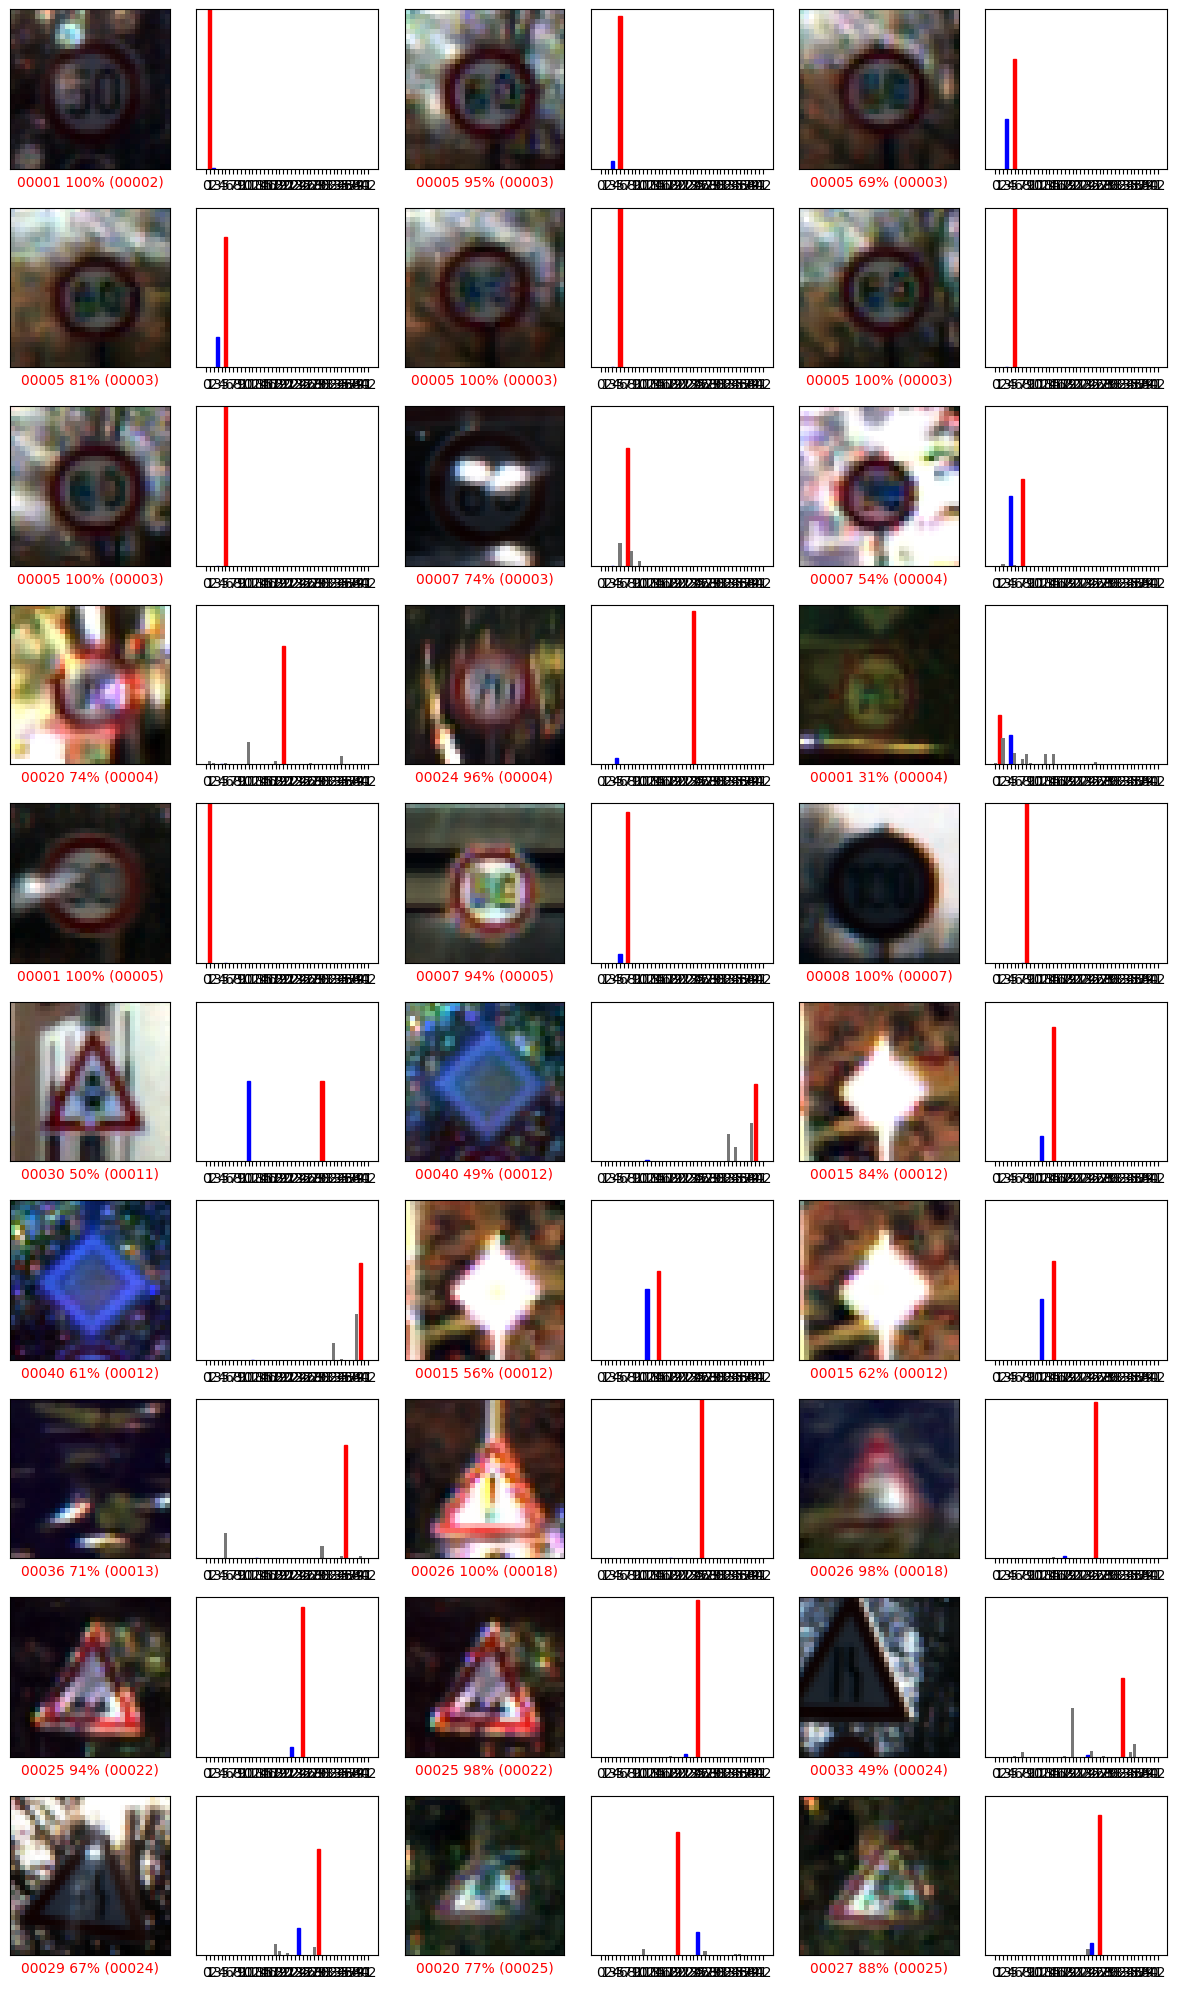

In [ ]:
show_bad_preds(model_I, test_loader, test_set.classes)